## Install the twitter library in python

General Notes and ideas:

* Did we think about retweets?
    -> if we have a lot of same tweets we get a huge bias. 
    
* In the analysis of the tweeets, histogram is very small for some reason
* ylimitation did not work properly

In [1]:
INIT_INSTALL = False

if(INIT_INSTALL):
    !pip install --user tweepy
    !pip install --user simplejson
    !pip install --user textblob
    !python -m textblob.download_corpora lite
    !pip install nltk
    !pip install plotly
    !pip install pycountry-convert
    !pip install translate
    !pip install indicoio

# Streaming tweets and perform some data analysis


### Setting up and running a streaming crawler

In [2]:
# crawler libs
import tweepy
import simplejson as json
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener

# wordcloud dependencies
import nltk
import wordcloud
import matplotlib.pyplot as plt  
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from wordcloud import WordCloud, STOPWORDS

# general plotting and stats libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from scipy.stats import pearsonr
import pickle

# geographical analysis lib 
import pycountry_convert as pc 
from googletrans import Translator

# sentiment analysis libs
import indicoio
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#Complete with your keys 

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 

class MyListener(StreamListener):
    
    def __init__(self, api=None):
        super(StreamListener, self).__init__()
        self.num_tweets = 0

    def on_data(self, data):
        try:
            with open('crawled_tweets.json', 'a', newline='') as f:
                # Filtering data only with info about the country
                if json.loads(data).get('place'): #checks that the attribute exists 
                    # if json.loads(data)['place']['country'] == target: select specific country = target
                    f.write(data) # This will store the whole JSON data in the file, you can perform some JSON filters
                    twitter_text = json.loads(data)['text'] # You can also print your tweets here
                    self.num_tweets += 1
                
                # Just to limit the number of tweets collected to check the 
                # program at the beginning, then increase the limit
                if self.num_tweets < 10: 
                    return True
                else:
                    return False
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True

 
    def on_error(self, status):
        print('Error :', status.place)
        return False
    
twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=["lgbt", "LGBT", "LGBTQ", "lgbtq", "lgbtq+", "LGBTQ+"]) # Add your keywords and other filters
print('_______ End _______')

### Store the JSON data in a CSV for analysing

In [ ]:
import simplejson as json

# Create the CSV file
with open ("data/LGBTQ_no_country.csv", 'w', encoding ='utf-8') as csv:
    # Write the title of the columns (features) that you want to store in the CSV file
    csv.write('id, created_at, followers, friends, favorite_count, verified, description, text \n')
    #country, followers, friends, text\n')
    
    # Copy the data from the JSON file
    with open('data/LGBTQ_no_country.json', 'r', encoding ='utf-8') as jsonfile:
        for tweet in jsonfile: 
            data = json.loads(tweet)
            text = str(data['text'].replace('\n', '').replace(",", "").replace('&','').replace('amp', '').replace('&amp;',''))
            id_ = str(data['id'])
            created_at = str(data['created_at'])
            #country = str(data['place']['country'])
            followers = str(data['user']['followers_count'])
            friends = str(data['user']['friends_count'])
            favorites = str(data['favorite_count'])
            verified = str(data['user']['verified'])
            description = ''
            if(data['user']['description']):
                description = str(data['user']['description'].replace('\n', '').replace(",", "").replace('amp', '').replace('&','').replace('&amp;',''))
            else: 
                description = ''
            line = id_+','+created_at+','+followers+','+friends+','+favorites+','+verified+','+description+','+text+'\n'
            #country+','+
            csv.write(line)

In [ ]:
import simplejson as json

# Create the CSV file
with open ("data/crawled_tweets.csv", 'w', encoding ='utf-8') as csv:
    # Write the title of the columns (features) that you want to store in the CSV file
    csv.write('id, created_at, country, followers, friends, favorite_count, verified, description, text \n')
    #country, followers, friends, text\n')
    
    # Copy the data from the JSON file
    with open('data/crawled_tweets.json', 'r', encoding ='utf-8') as jsonfile:
        for tweet in jsonfile: 
            data = json.loads(tweet)
            text = str(data['text'].replace('\n', '').replace(",", "").replace('&','').replace('amp', '').replace('&amp;',''))
            id_ = str(data['id'])
            created_at = str(data['created_at'])
            country = str(data['place']['country'])
            followers = str(data['user']['followers_count'])
            friends = str(data['user']['friends_count'])
            favorites = str(data['favorite_count'])
            verified = str(data['user']['verified'])
            description = ''
            if(data['user']['description']):
                description = str(data['user']['description'].replace('\n', '').replace(",", "").replace('amp', '').replace('&','').replace('&amp;',''))
            else: 
                description = ''
            line = id_+','+created_at+','+country+','+followers+','+friends+','+favorites+','+verified+','+description+','+text+'\n'
            #country+','+
            csv.write(line)

### Load the previous CSV into pandas

In [3]:
tweets = pd.read_csv('data/LGBTQ_no_country.csv', index_col=0, encoding='utf-8', sep=r'\s*,\s*', engine='python')
tweets = tweets.dropna()
tweets.head(20)

,created_at,followers,friends,favorite_count,verified,description,text
id,,,,,,,
1218938315472195584,Sun Jan 19 16:48:35 +0000 2020,957.0,1561.0,0.0,False,Lesbian | Insignificant Neoconservative Ideolo...,Socialism benefits no one
1218938318135746562,Sun Jan 19 16:48:36 +0000 2020,14.0,131.0,0.0,False,🐶,@atahasnain53 Sir would you be willing to comm...
1218938324058103808,Sun Jan 19 16:48:37 +0000 2020,190.0,146.0,0.0,False,Just some bisexual idiot on the Internet. Slut...,@satiricole @AllianceLGB A transphobe was kick...
1218938330370519040,Sun Jan 19 16:48:39 +0000 2020,3829.0,4841.0,0.0,False,#Spoonie #NoStigma #NoH8 #LoveWins #RESIST #W...,RT @Jersey_Craig: The US Hasn't Only Stopped D...
1218938351337660421,Sun Jan 19 16:48:44 +0000 2020,296.0,403.0,0.0,False,Come Back Soon Woojin 🐻💙,RT @kpophappenings_: when that kpop boy played...
1218938356140331009,Sun Jan 19 16:48:45 +0000 2020,156.0,119.0,0.0,False,23. Professional nerd. Amateur musician. Quest...,idk who he is but we stan hard 😤😤😤😤😤😤😤😤😤😤😤😤😤😤
1218938357918715906,Sun Jan 19 16:48:45 +0000 2020,403.0,349.0,0.0,False,Je débarque dans ta vie en claquettes secondai...,@CharlotteThuil3 Mes mains sont lgbtq
1218938379548725249,Sun Jan 19 16:48:51 +0000 2020,243.0,1105.0,0.0,False,#BARON ; ☺️ i‘m the cutest babie alive,RT @kpophappenings_: when that kpop boy played...
1218938380983132162,Sun Jan 19 16:48:51 +0000 2020,981.0,969.0,0.0,False,rachel the anarchist. not a tolerant leftist. ...,she is just your version of gun girl. you t e ...


In [4]:
tweets_country = pd.read_csv('data/crawled_tweets.csv', index_col = 0, encoding = 'utf-8', sep = r'\s*,\s*', engine = 'python')
tweets_country = tweets_country.dropna()
tweets_country.head(20)

,created_at,country,followers,friends,favorite_count,verified,description,text
id,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brasil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brasil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...
1218196878824759296,Fri Jan 17 15:42:23 +0000 2020,France,1085,396,0,False,https://damocles.co/non-islamisation-france/si...,@Bugul_Noz @SignalZoorah @Neliak997755 @HughRo...
1218197171364925440,Fri Jan 17 15:43:33 +0000 2020,Panamá,315,222,0,False,No me vengan con mamadas 🌸🥰,Estas si las quiero para mi y mis cuecos 😭
1218197239866241027,Fri Jan 17 15:43:49 +0000 2020,United States,2904,354,0,False,the girl of your fever dreams,take a look at this dumbass cracker
1218197769199988736,Fri Jan 17 15:45:55 +0000 2020,France,257,276,0,False,📍#Paris 🇫🇷🇵🇹 I solemnly swear that I am up to ...,Connard de merde... Ou « Biggest Piece Of Shit...


### Analysing the polarity of the tweets

In [118]:
# Go through all tweets without country and calculate sentiment
for index in tweets.index: 
    # Retrieve tweet for index i.e. id
    tweet = tweets.loc[index, 'text']

    # Calculate sentiment
    blob = TextBlob(tweet)

    # Concatenate polarity and subj into dataframe sentiment (columns: index, polar, subj)
    tweets.loc[index, 'polar'] = blob.sentiment[0]
    tweets.loc[index, 'subj'] = blob.sentiment[1]

In [61]:
# Go through all tweets with country and calculate sentiment
for index in tweets_country.index: 
    # Retrieve tweet for index i.e. id
    tweet = tweets_country.loc[index, 'text']

    # Calculate sentiment
    blob = TextBlob(tweet)

    # Concatenate polarity and subj into dataframe sentiment (columns: index, polar, subj)
    tweets_country.loc[index, 'polar'] = blob.sentiment[0]
    tweets_country.loc[index, 'subj'] = blob.sentiment[1]

In [64]:
tweets_country.head()

,created_at,country,followers,friends,favorite_count,verified,description,text,polar_native,detected_lang,iso_alpha_3,polar,subj
id,,,,,,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brazil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara,0.526588,Portuguese,BRA,0.000000,0.000000
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brazil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...,0.668481,Portuguese,BRA,0.000000,0.000000
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...,0.628498,English,USA,0.000000,0.000000
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...,0.772649,English,GBR,0.472917,0.645833
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...,0.734077,English,USA,0.433333,0.466667


In [8]:
tweets['polar'].describe()

count    1825.000000
mean        0.109242
std         0.313517
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.400000
max         1.000000
Name: polar, dtype: float64

In [9]:
tweets['subj'].describe()

count    1825.000000
mean        0.421778
std         0.331061
min         0.000000
25%         0.000000
50%         0.500000
75%         0.641667
max         1.000000
Name: subj, dtype: float64

In [126]:
def create_polar_histo (df): 
    plt.hist(df['polar'], bins='auto', color='#0504aa', alpha=0.7,)
    plt.ylabel('Frequency')
    plt.xlabel('Polarity [-1, 1]')

In [127]:
def create_subj_histo (df): 
    plt.hist(df['subj'], bins='auto', color='#0504aa', alpha=0.7,)
    plt.ylabel('Frequency')
    plt.xlabel('Subjectivity [0, 1]')

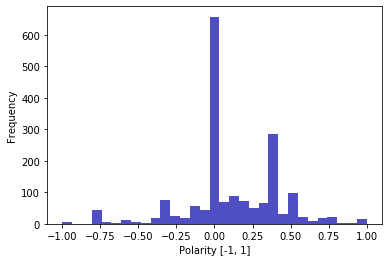

In [12]:
create_polar_histo(tweets)

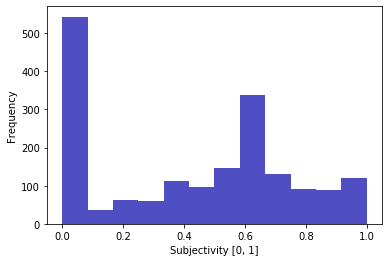

In [13]:
create_subj_histo(tweets)

### Indicio Sentiment analyis with different languages

In [5]:
indicoio.config.api_key = '28637e70bd45c2998ef311ec52b088a0'

In [8]:
# Go through all tweets with country and calculate sentiment
for index in tweets_country.index: 
    # Retrieve tweet for index i.e. id
    tweet = tweets_country.loc[index, 'text']
    
    # Retrieve dictionary with lang and prob pairs
    lang_dic = indicoio.language(tweet)

    # Detect language
    tweets_country.loc[index, 'detected_lang'] = max(lang_dic.keys(), key=(lambda key: lang_dic[key])) 

    # Calculate sentiment
    tweets_country.loc[index, 'polar_native'] = indicoio.sentiment(tweet)

In [10]:
tweets_country.head()

,created_at,country,followers,friends,favorite_count,verified,description,text,polar_native,detected_lang
id,,,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brasil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara,0.526588,Portuguese
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brasil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...,0.668481,Portuguese
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...,0.628498,English
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...,0.772649,English
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...,0.734077,English


In [59]:
if 'polar_native' in tweets_country.columns:
    pickle.dump(tweets_country, open( "data/tweets_country.p", "wb"))
    print("File saved")
else:
    tweets_country = pickle.load(open("data/tweets_country.p", "rb"))
    print("File loaded")

File saved


### Generating a wordcloud

In [14]:
def word_count(series):
    wordcount_dict = dict()
    for text in series:
        text = str(text)
        words = text.split()
        
        for word in words: 
            if word in wordcount_dict: 
                wordcount_dict[word] += 1
            else: 
                wordcount_dict[word] = 1 
    return wordcount_dict
            
    
#First, create the dictionary used to produce the genre wordcloud    
wordcount_dict = word_count(tweets['text'])

In [15]:
#words to remove from the counter
stop_words = stopwords.words('english')

additional_Stopwords = ['LGBT','#LGBT', 'LGBT','LGBTQ','#LGBTQ', 'LGBTQ+',
                        'lgbtq', 'lgbtq+','#lgbtq', 'lgbt', '#lgbt',
                        'de', 'se', 'la', 'I', 'The', 'RT' ]


for stopword in additional_Stopwords: 
    stop_words.append(stopword)   

In [16]:
def remove_words(word_dict, removal_list): 
    copy_dict = dict(word_dict)
    for word in removal_list: 
        copy_dict[word] = 0
    
    return copy_dict

wordcount_dict_clean = remove_words(wordcount_dict, stop_words)

In [17]:
#Second, create the wordcloud
# - create object "genre_wordcloud = WordCloud(...)"
# - generate word cloud from frequencies in "genres"
wordcloud = WordCloud(background_color="white")
wordcloud = wordcloud.generate_from_frequencies(wordcount_dict_clean)

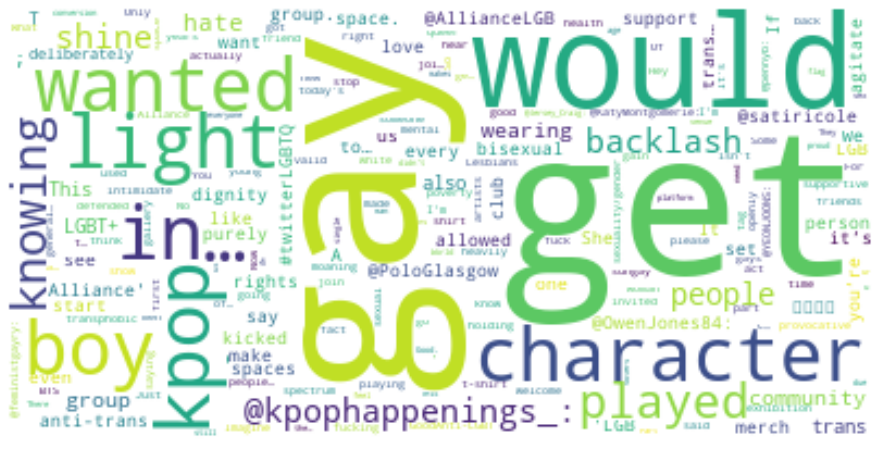

In [18]:
# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Geographical Analysis

In [11]:
# Map key error values based on dictionary
country_dic = {"Brasil": "Brazil", "Panamá": "Panama", "ประเทศไทย": "Thailand", "México": "Mexico", "Estados Unidos": "United States", "Schweiz": "Switzerland", "Deutschland": "Germany", "België": "Belgium", "Italia": "Italy", "Canadá": "Canadá", "Holanda": "Netherlands", "日本": "Japan", "Danmark": "Denmark", "Türkiye": "Turkey", "Republic of Korea": "South Korea", "Royaume-Uni": "United Kingdom", "España" : "Spain", "Canadá" : "Canada","Italie" : "Italy" }
tweets_country['country'].replace(country_dic, inplace = True)

In [ ]:
# Better solution

translate_urls = ["translate.google.com", "translate.google.co.kr",
                      "translate.google.at", "translate.google.de",
                      "translate.google.ru", "translate.google.ch",
                      "translate.google.fr", "translate.google.es"]

# Translate 
translator = Translator(service_urls=translate_urls)   
tweets_country['trans_country'] = [translator.translate(orig_country).text for orig_country in tweets_country['country']]

In [12]:
for index in tweets_country.index: 
    single_country = tweets_country.loc[index, 'country']
    try:
        country_iso_alpha_3 = pc.country_name_to_country_alpha3(single_country, cn_name_format="default")
        tweets_country.loc[index, 'iso_alpha_3'] = country_iso_alpha_3
    except KeyError as e:
        print('KeyError - reason {}'.format(str(e)))
        tweets_country.loc[index, 'iso_alpha_3'] = ''
    except IndexError as e:
        print('I got an IndexError - reason {}'.format(str(e)))
    except TypeError as e:
        tweets_country.loc[index, 'iso_alpha_3'] = ''
        print('I got an TypeError - reason {}'.format(str(e)))

In [13]:
tweets_country.head()

,created_at,country,followers,friends,favorite_count,verified,description,text,polar_native,detected_lang,iso_alpha_3
id,,,,,,,,,,,
1218195973513629696,Fri Jan 17 15:38:47 +0000 2020,Brazil,1808,1585,0,False,What is the nature of your reality?,Q ódio eu tenho desse cara,0.526588,Portuguese,BRA
1218196070527897603,Fri Jan 17 15:39:10 +0000 2020,Brazil,626,1021,0,False,Eu não faço a menor ideia do que eu tô fazendo...,Eu vou até evitar essas discussões de rolês de...,0.668481,Portuguese,BRA
1218196078035718146,Fri Jan 17 15:39:12 +0000 2020,United States,348,695,0,False,Father of 4 great kids husband to a great wif...,Your five minutes are up but thank you for doi...,0.628498,English,USA
1218196163620413442,Fri Jan 17 15:39:33 +0000 2020,United Kingdom,4318,1098,0,False,just straight vibin,me and my friends are going to an LGBT (partic...,0.772649,English,GBR
1218196522283737089,Fri Jan 17 15:40:58 +0000 2020,United States,1016,315,0,False,Founder/Director of CenterPeace creating space...,STARTS TODAY! For many Tapestry is the 1st tim...,0.734077,English,USA


In [21]:
tweets_country[tweets_country['country'] == 'Canada'].describe()

,followers,friends,favorite_count,polar_native
count,18.000000,18.000000,18.0,18.000000
mean,2391.444444,1359.222222,0.0,0.451767
std,4351.244328,1517.010433,0.0,0.330454
min,124.000000,142.000000,0.0,0.000611
25%,441.000000,362.750000,0.0,0.182949
50%,1235.000000,606.000000,0.0,0.391473
75%,2144.000000,1825.000000,0.0,0.722838
max,19139.000000,4982.000000,0.0,0.979754


In [65]:
mean_country_df = tweets_country.groupby(['iso_alpha_3', 'country']).agg(['mean', 'count']).reset_index() # not a clean way to count
mean_country_df.head()

iso_alpha_3               country    followers            friends        \
                                            mean count         mean count   
0         ARE  United Arab Emirates   571.000000     1   526.000000     1   
1         ARG             Argentina  4534.714286     7  1455.571429     7   
2         AUS             Australia   861.000000    11   901.909091    11   
3         BEL               Belgium  5971.000000     1  1794.000000     1   
4         BGD            Bangladesh  1335.000000     1  2637.000000     1   

  favorite_count       verified       polar_native           polar        \
            mean count     mean count         mean count      mean count   
0              0     1      0.0     1     0.496238     1  0.000000     1   
1              0     7      0.0     7     0.321186     7  0.130952     7   
2              0    11      0.0    11     0.721395    11  0.271212    11   
3              0     1      1.0     1     0.140566     1  0.000000     1   
4              0     1      0.0     1     0.752787     1  0.159375     1   

       subj        
       mean count  
0  0.000000     1  
1  0.202381     7  
2  0.375000    11  
3  0.000000     1  
4  0.596875     1

In [66]:
mean_country_df.columns = ['_'.join(col).rstrip('_') for col in mean_country_df.columns.values]
mean_country_df.head()

,iso_alpha_3,country,followers_mean,followers_count,friends_mean,friends_count,favorite_count_mean,favorite_count_count,verified_mean,verified_count,polar_native_mean,polar_native_count,polar_mean,polar_count,subj_mean,subj_count
0,ARE,United Arab Emirates,571.000000,1,526.000000,1,0,1,0.0,1,0.496238,1,0.000000,1,0.000000,1
1,ARG,Argentina,4534.714286,7,1455.571429,7,0,7,0.0,7,0.321186,7,0.130952,7,0.202381,7
2,AUS,Australia,861.000000,11,901.909091,11,0,11,0.0,11,0.721395,11,0.271212,11,0.375000,11
3,BEL,Belgium,5971.000000,1,1794.000000,1,0,1,1.0,1,0.140566,1,0.000000,1,0.000000,1
4,BGD,Bangladesh,1335.000000,1,2637.000000,1,0,1,0.0,1,0.752787,1,0.159375,1,0.596875,1


In [67]:
# Plot polarity for country
fig = px.choropleth(mean_country_df, 
                    locations="iso_alpha_3",
                    color="polar_native_mean", # Polarity heat map
                    hover_name="country", # column to add to hover information
                    color_continuous_scale = px.colors.diverging.Tealrose[::-1],
                    color_continuous_midpoint = 0.5)
fig.show()

In [72]:
# Plot subjectivity for country
fig = px.choropleth(mean_country_df, 
                    locations="iso_alpha_3",
                    color="subj_mean", # Polarity heat map
                    hover_name="country", # column to add to hover information
                    color_continuous_scale = px.colors.diverging.Tealrose,
                    color_continuous_midpoint = 0.5)
fig.show()

### Country frequency of sampled data

In [90]:
thres = (mean_country_df['polar_count'].sum() / 100) * 2
mean_country_df['country_plot'] = np.where((mean_country_df['polar_count'] > thres), mean_country_df['country'], 'Others')
mean_country_df['country_plot'].head()

0    Others
1    Others
2    Others
3    Others
4    Others
Name: country_plot, dtype: object

In [91]:
mean_country_plot_df = mean_country_df.groupby(mean_country_df['country_plot']).agg('sum').reset_index()
mean_country_plot_df

,country_plot,followers_mean,followers_count,friends_mean,friends_count,favorite_count_mean,favorite_count_count,verified_mean,verified_count,polar_native_mean,polar_native_count,polar_mean,polar_count,subj_mean,subj_count
0,Brazil,1225.090909,88,914.670455,88,0,88,0.000000,88,0.532925,88,0.007434,88,0.039039,88
1,Canada,2391.444444,18,1359.222222,18,0,18,0.055556,18,0.451767,18,0.175829,18,0.416321,18
2,France,815.411765,17,557.647059,17,0,17,0.000000,17,0.606419,17,-0.008824,17,0.032353,17
3,Italy,937.764706,17,992.588235,17,0,17,0.000000,17,0.559901,17,0.353248,17,0.506127,17
4,Mexico,1877.285714,14,945.142857,14,0,14,0.000000,14,0.644250,14,0.068452,14,0.077976,14
5,Others,63239.824603,127,40074.145202,127,0,127,1.583333,127,21.157640,127,2.193556,127,6.571283,127
6,United Kingdom,2479.785714,56,2131.125000,56,0,56,0.000000,56,0.488117,56,0.156946,56,0.401282,56
7,United States,3363.792627,217,2276.552995,217,0,217,0.013825,217,0.521267,217,0.106377,217,0.343492,217


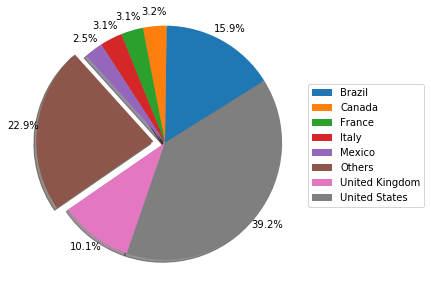

In [175]:
labels = mean_country_plot_df['country_plot']
sizes = mean_country_plot_df['polar_count'] # Count has to be changed
explode = (0, 0, 0, 0, 0, 0.1, 0, 0)
#colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
patches, texts, junk = plt.pie(sizes, explode= explode, shadow=True, startangle=32, autopct='%1.1f%%', pctdistance=1.12)
plt.legend(patches, labels, bbox_to_anchor=(1, 0.75))
plt.axis('equal')
plt.tight_layout()
plt.show()

### Impact of Followers and Favorites on Polarity and Subjectivity

Text(0, 0.5, '# Followers')

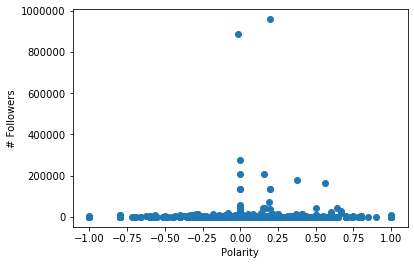

In [119]:
plt.scatter(tweets['polar'], tweets['followers'])
plt.xlabel('Polarity')
plt.ylabel('# Followers')

Text(0, 0.5, '# Followers')

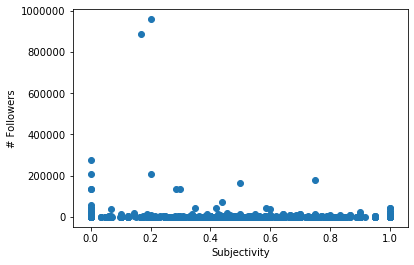

In [120]:
plt.scatter(tweets['subj'], tweets['followers'])
plt.xlabel('Subjectivity')
plt.ylabel('# Followers')

In [121]:
# calculate Pearson's correlation
corr_pol, _ = pearsonr(tweets['polar'], tweets['followers'])
print('Pearsons correlation between #followers and polarity: %.3f' % corr_pol)

corr_subj, _ = pearsonr(tweets['subj'], tweets['followers'])
print('Pearsons correlation between #followers and subjectivity: %.3f' % corr_subj)

Pearsons correlation between #followers and polarity: 0.003
Pearsons correlation between #followers and subjectivity: -0.041


Text(0, 0.5, '# Favorites')

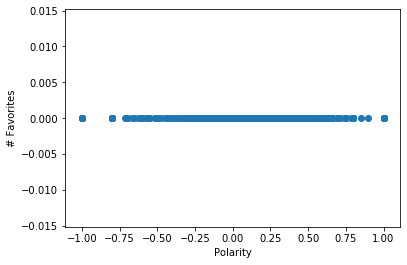

In [122]:
plt.scatter(tweets['polar'], tweets['favorite_count'])
plt.xlabel('Polarity')
plt.ylabel('# Favorites')

### Analysis by word

In [123]:
tweets_containing_gay = tweets.loc[tweets['text'].str.contains('gay')]
tweets_containing_queer = tweets.loc[tweets['text'].str.contains('queer')]
tweets_containing_flag = tweets.loc[tweets['text'].str.contains('🌈|🏳️‍🌈')]
tweets_containing_kpop = tweets.loc[tweets['text'].str.contains('kpop')]

### Analysis of the word gay

In [124]:
tweets_containing_gay.describe()

,followers,friends,favorite_count,polar,subj
count,342.000000,342.000000,342.0,342.000000,342.000000
mean,715.052632,862.383041,0.0,0.333736,0.558508
std,1490.122152,1214.254995,0.0,0.179167,0.214773
min,0.000000,0.000000,0.0,-0.291667,0.000000
25%,91.250000,222.250000,0.0,0.333333,0.585417
50%,281.500000,500.500000,0.0,0.408333,0.641667
75%,710.250000,1016.500000,0.0,0.408333,0.641667
max,13971.000000,14078.000000,0.0,0.800000,0.950000


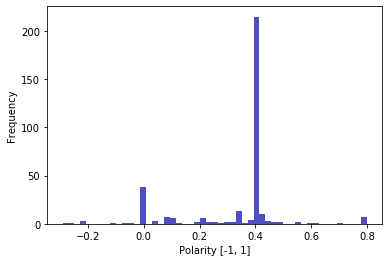

In [128]:
create_polar_histo(tweets_containing_gay)

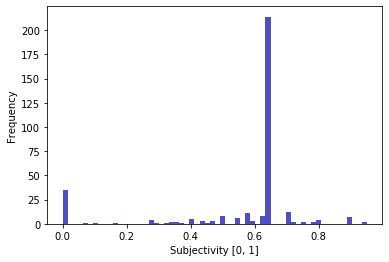

In [129]:
create_subj_histo(tweets_containing_gay)

### Analysis of the word queer

In [130]:
tweets_containing_queer.describe()

,followers,friends,favorite_count,polar,subj
count,43.000000,43.000000,43.0,43.000000,43.000000
mean,1132.953488,1313.720930,0.0,0.037339,0.442151
std,2055.426198,1468.339187,0.0,0.352953,0.382099
min,3.000000,24.000000,0.0,-0.800000,0.000000
25%,133.000000,236.000000,0.0,0.000000,0.000000
50%,352.000000,900.000000,0.0,0.000000,0.458333
75%,946.500000,2154.000000,0.0,0.185417,0.766667
max,9926.000000,6601.000000,0.0,0.800000,1.000000


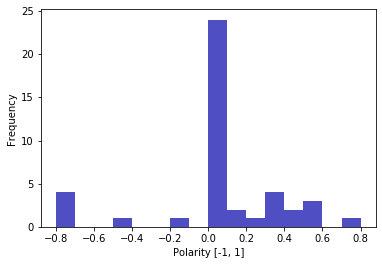

In [131]:
create_polar_histo(tweets_containing_queer)

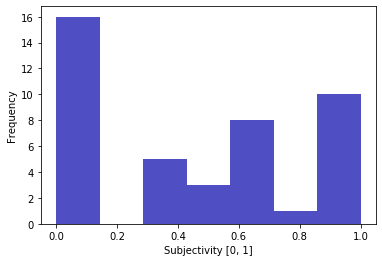

In [132]:
create_subj_histo(tweets_containing_queer)

### Analysis of tweets contiaining the flag

In [133]:
tweets_containing_flag.describe()

,followers,friends,favorite_count,polar,subj
count,83.000000,83.000000,83.0,83.000000,83.000000
mean,865.927711,940.265060,0.0,0.143130,0.294661
std,1329.003219,1306.880227,0.0,0.223474,0.396489
min,0.000000,0.000000,0.0,-0.250000,0.000000
25%,116.000000,71.500000,0.0,0.000000,0.000000
50%,449.000000,421.000000,0.0,0.000000,0.000000
75%,973.500000,1098.000000,0.0,0.400000,0.600000
max,8272.000000,5001.000000,0.0,0.512500,1.000000


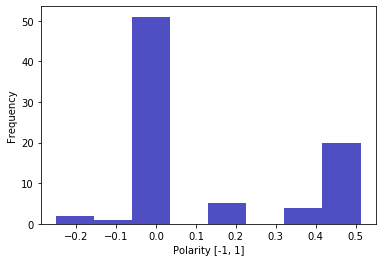

In [135]:
create_polar_histo(tweets_containing_flag)

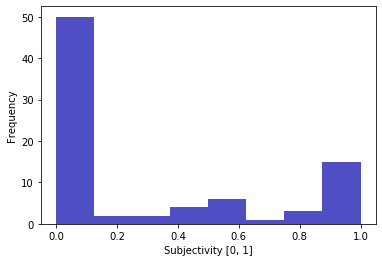

In [136]:
create_subj_histo(tweets_containing_flag)

### Analysis of tweets containing kpop

In [137]:
tweets_containing_kpop.describe()

,followers,friends,favorite_count,polar,subj
count,215.000000,215.000000,215.0,215.000000,215.000000
mean,568.902326,750.511628,0.0,0.406667,0.639341
std,1124.856271,827.475560,0.0,0.026169,0.023148
min,2.000000,25.000000,0.0,0.025000,0.316667
25%,91.500000,222.500000,0.0,0.408333,0.641667
50%,267.000000,475.000000,0.0,0.408333,0.641667
75%,601.000000,941.500000,0.0,0.408333,0.641667
max,12681.000000,5003.000000,0.0,0.416667,0.641667


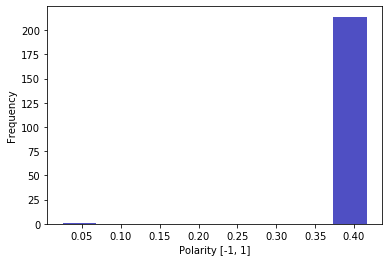

In [138]:
create_polar_histo(tweets_containing_kpop)

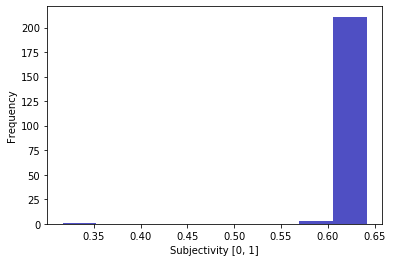

In [139]:
create_subj_histo(tweets_containing_kpop)

### Correlation between polarity and verification

In [142]:
not_verified = tweets.loc[tweets['verified'] =='False']
verified = tweets.loc[tweets['verified'] == 'True']

In [143]:
verified.count()

created_at        15
followers         15
friends           15
favorite_count    15
verified          15
description       15
text              15
polar             15
subj              15
dtype: int64

### Analysis of Reporting of Journalists

In [144]:
journalist_tweets = tweets.loc[tweets['description'].str.contains('Journalist|jorunalist|JOURNALIST|Reporter|reporter|REPORTER')]

In [145]:
journalist_tweets.count()

created_at        3
followers         3
friends           3
favorite_count    3
verified          3
description       3
text              3
polar             3
subj              3
dtype: int64